# Packages

In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 1. Dataset

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

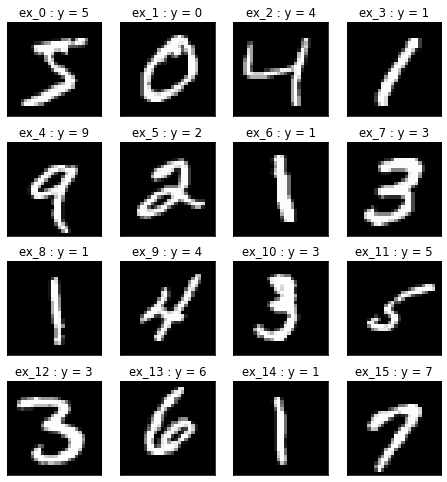

In [3]:
# plt.imshow(x_train[0],cmap='gray')
# plt.show()

fig, ax = plt.subplots(4, 4, figsize=(8, 8.5), dpi=70)
k = 0
for ax in fig.get_axes():
  ax.imshow(x_train[k], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title('ex_' + str(k) +' : y = '+ str(y_train[k]))
  k = k + 1

# 2. Preprocessing

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
# Ensure images are in the format (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
y_train # before

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
# Convert numbers to binary matrices (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
y_train # after

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [9]:
y_train.shape

(60000, 10)

# 3. Convolutional Neural Network (CNN)

In [10]:
# Model
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax'),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [11]:
batch_size = 128
epochs = 50

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train,
          y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.1,
          callbacks = [callback])

Epoch 1/50
422/422 [==============================] - 8s 18ms/step - loss: 0.3663 - accuracy: 0.8904 - val_loss: 0.0801 - val_accuracy: 0.9788
Epoch 2/50
422/422 [==============================] - 8s 18ms/step - loss: 0.1059 - accuracy: 0.9677 - val_loss: 0.0595 - val_accuracy: 0.9837
Epoch 3/50
422/422 [==============================] - 8s 18ms/step - loss: 0.0833 - accuracy: 0.9740 - val_loss: 0.0458 - val_accuracy: 0.9890
Epoch 4/50
422/422 [==============================] - 8s 18ms/step - loss: 0.0671 - accuracy: 0.9794 - val_loss: 0.0430 - val_accuracy: 0.9890
Epoch 5/50
422/422 [==============================] - 8s 19ms/step - loss: 0.0623 - accuracy: 0.9804 - val_loss: 0.0355 - val_accuracy: 0.9910
Epoch 6/50
422/422 [==============================] - 8s 19ms/step - loss: 0.0540 - accuracy: 0.9830 - val_loss: 0.0333 - val_accuracy: 0.9910
Epoch 7/50
422/422 [==============================] - 8s 19ms/step - loss: 0.0487 - accuracy: 0.9850 - val_loss: 0.0339 - val_accuracy: 0.9905

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.024736639112234116
Test accuracy: 0.9919999837875366


In [13]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


# 4. Results

## 4.1 Feature Maps

In [14]:
from keras import backend as K

input_tensor = model.input

layer_outputs = [layer.output for layer in model.layers]

fetch_functions = [K.function([input_tensor], [output]) for output in layer_outputs]

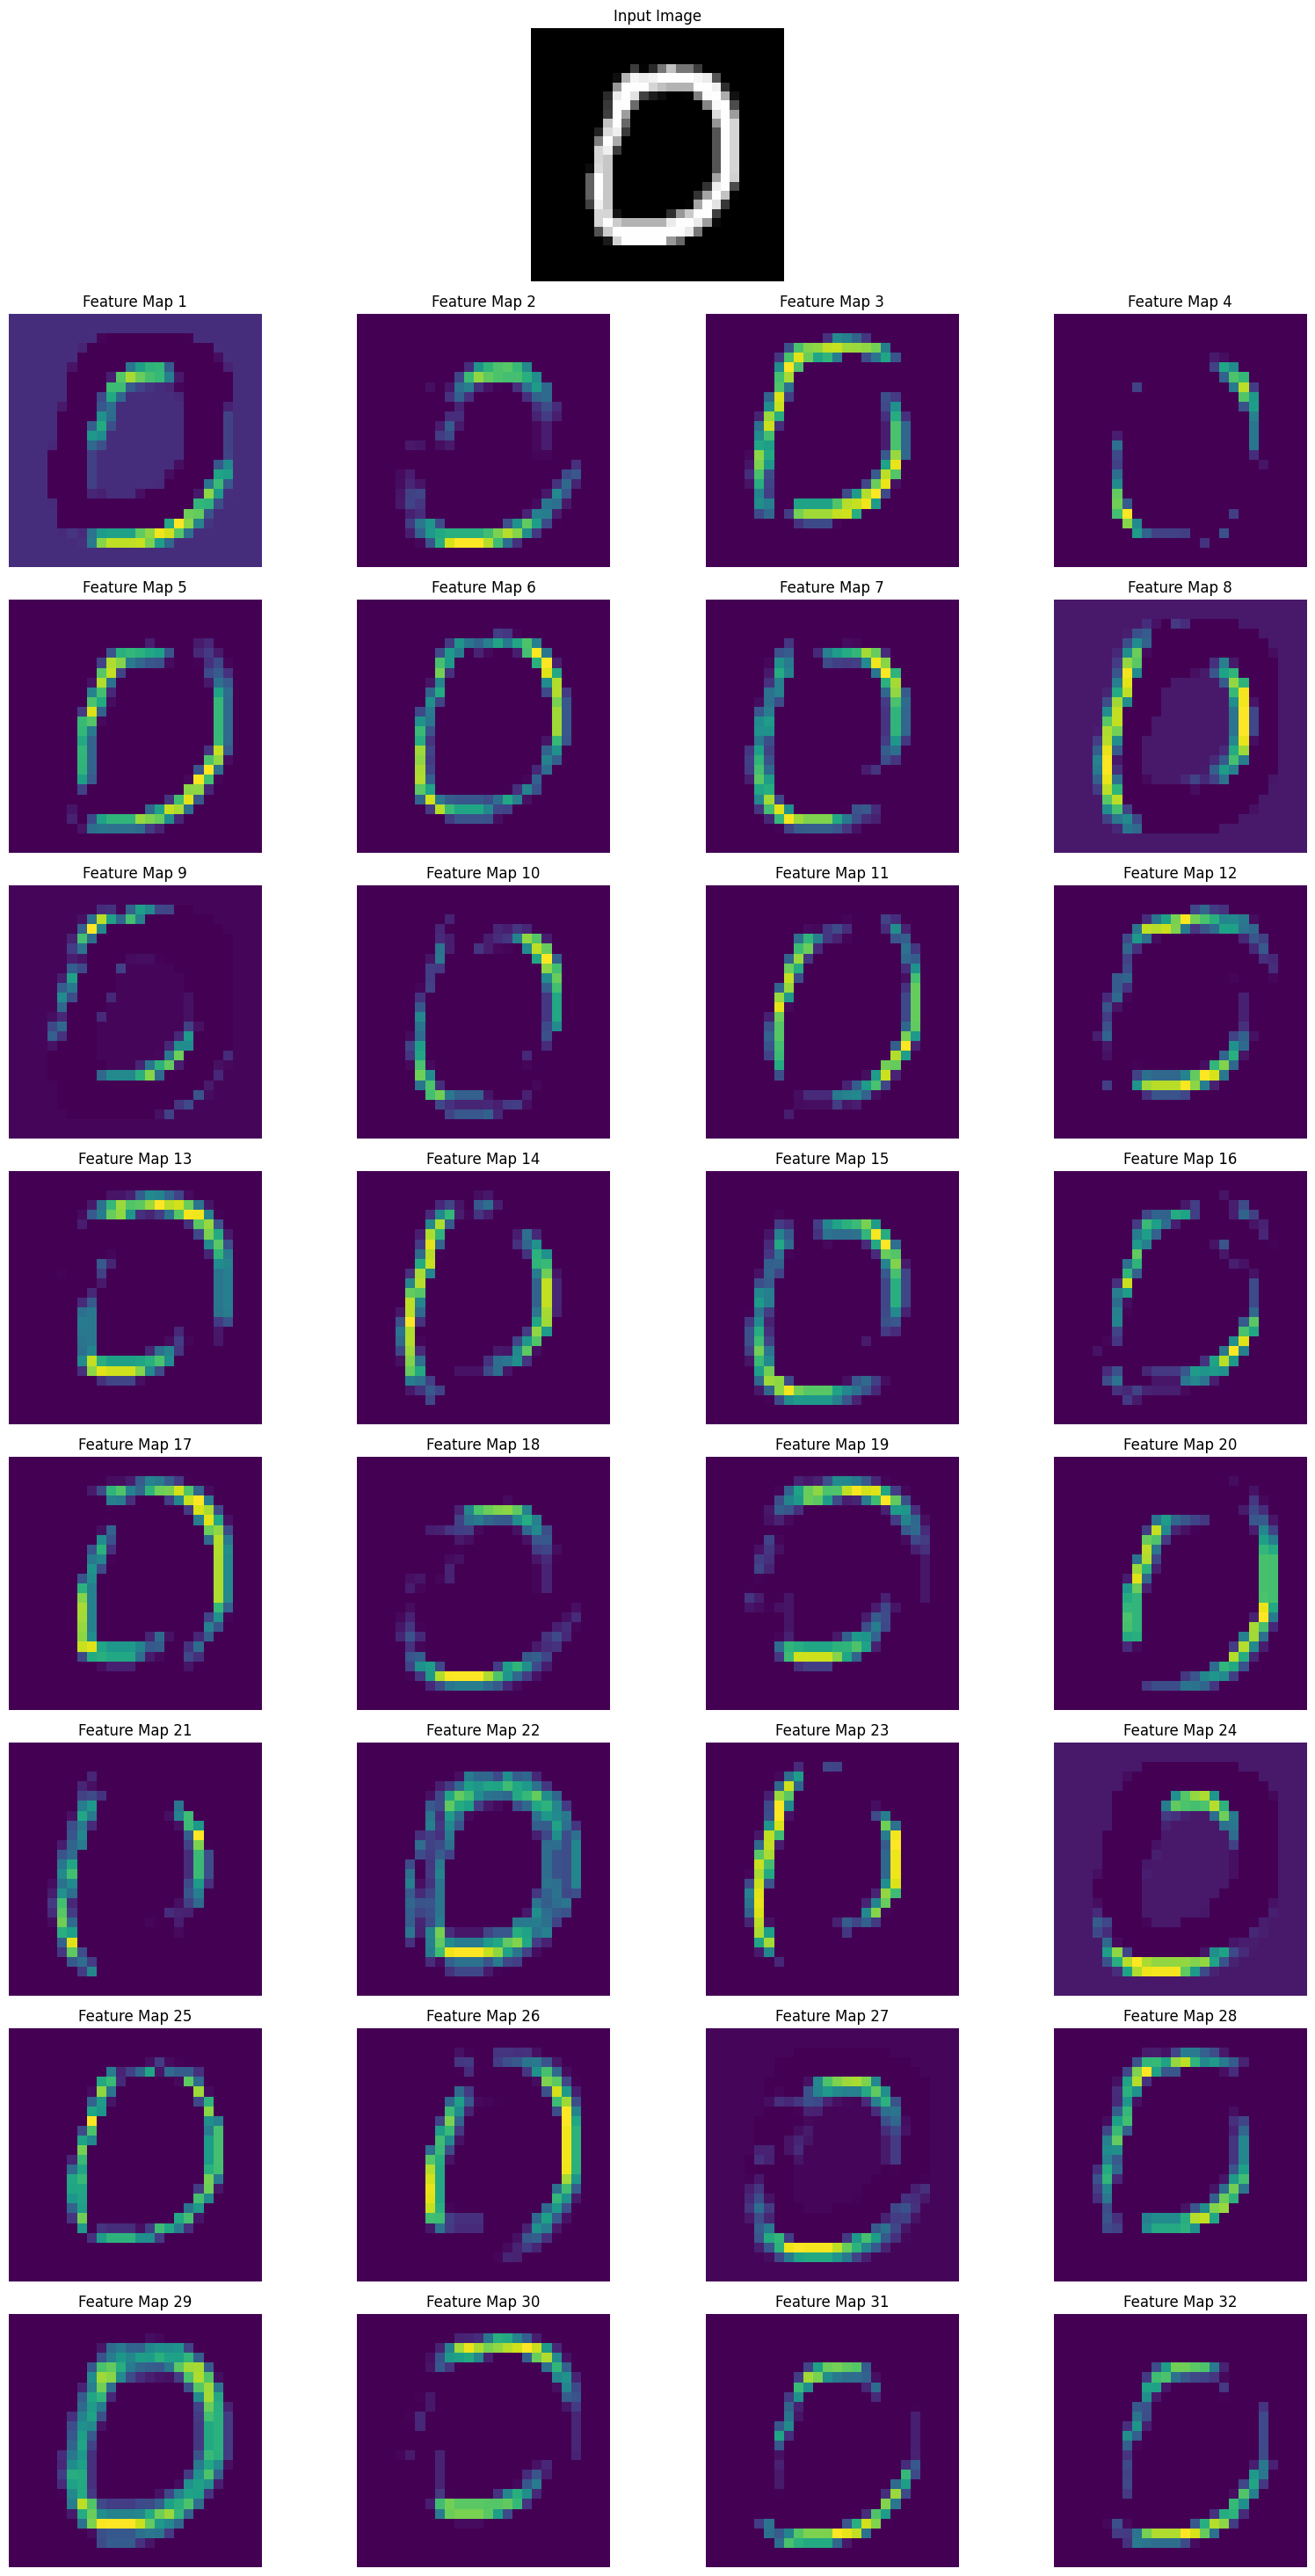

In [15]:
example = 10

input_data = x_test[example]
input_data = np.expand_dims(input_data, axis=0)
layer_outputs_values = [func([input_data]) for func in fetch_functions]

fig = plt.figure(figsize=(16, 30))
gs = GridSpec(9, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(x_test[example], cmap='gray')
ax1.set_title('Input Image')
ax1.axis('off')

map = 0
num_feature_maps = layer_outputs_values[0][0].shape[3]

for i in range(1, 9):  # 8 linhas seguintes
    for j in range(4):  # 4 colunas por linha
        ax = fig.add_subplot(gs[i, j])
        if map < num_feature_maps:
            feature_map = layer_outputs_values[0][0][:, :, :, map].reshape(26, 26)
            ax.imshow(feature_map, cmap='viridis')
            ax.set_title('Feature Map {}'.format(map + 1))
            ax.axis('off')
            map += 1
        else:
            ax.axis('off')

plt.savefig('CNN_results/feature_maps.jpeg')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## 4.2 Kernels

In [16]:
# First Convolutional Layer
conv_layer1 = model.layers[0].get_weights()

kernels, biases = conv_layer1

In [17]:
print(kernels.shape)
print(biases.shape)

(3, 3, 1, 32)
(32,)


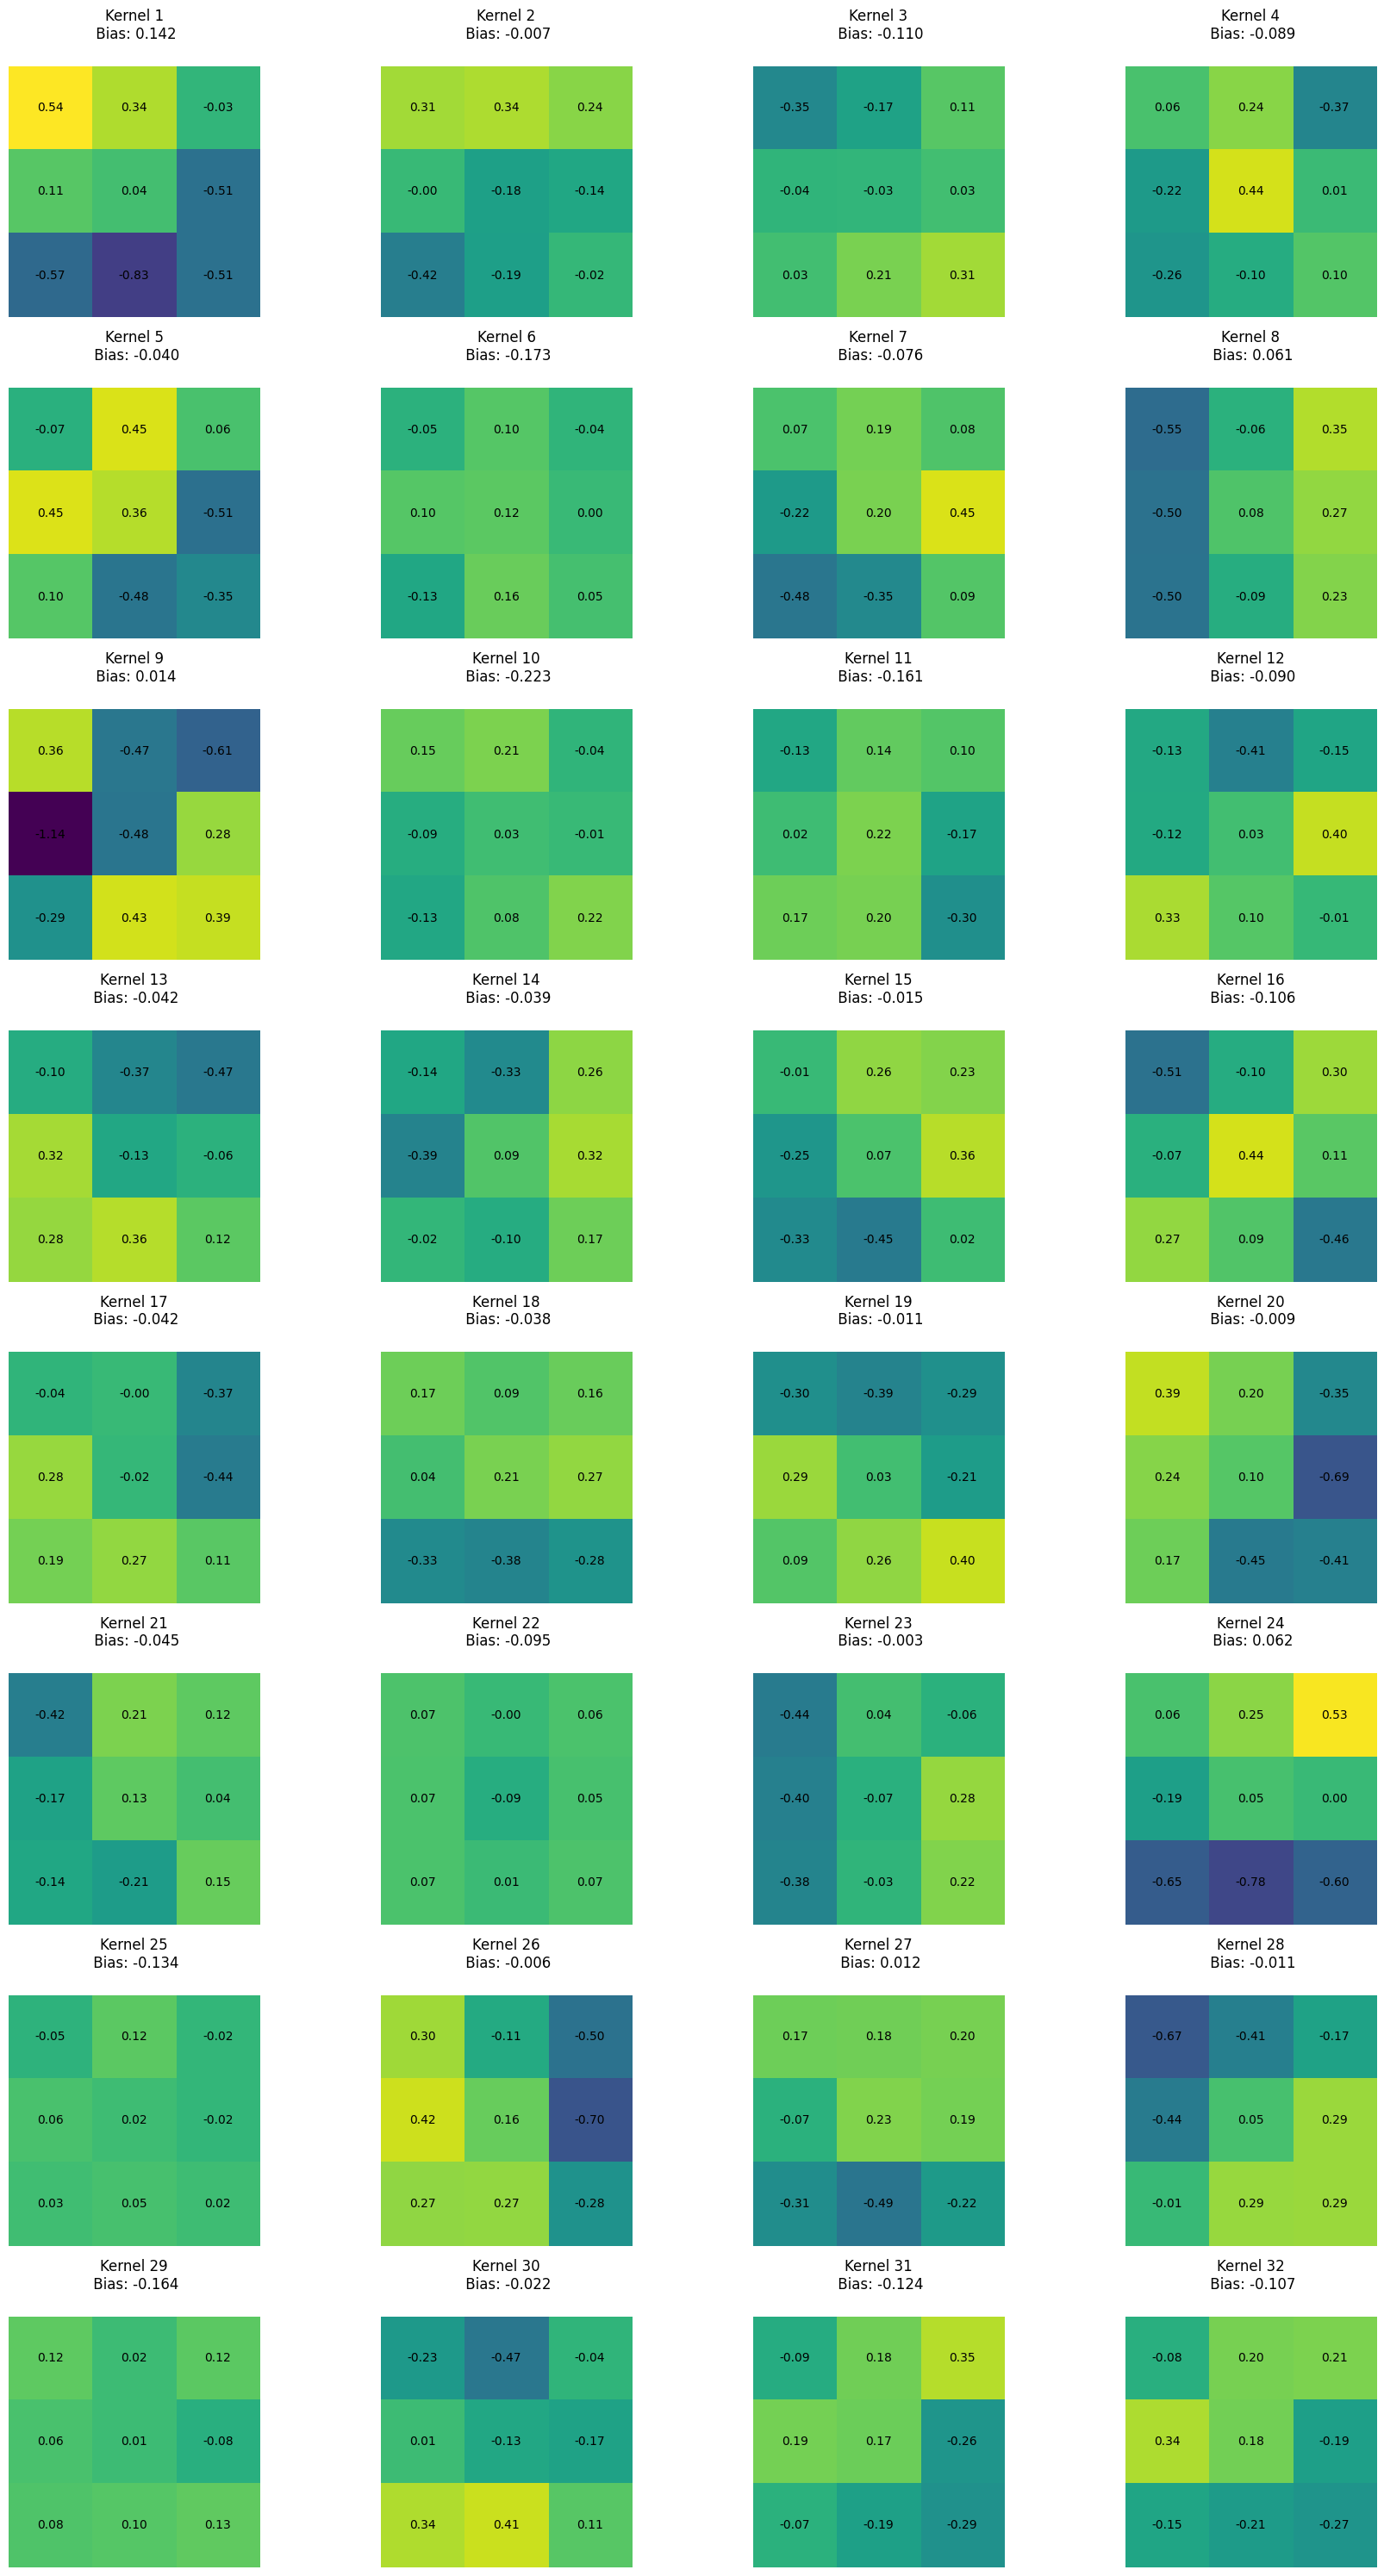

In [18]:
nrows = 8
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 30))

vmin = kernels.min()
vmax = kernels.max()

k_i = 0

for i in range(nrows):

    for j in range(ncols):

        kernel = kernels[:, :, :, k_i].reshape(3, 3)

        bias = biases[k_i]

        axes[i, j].matshow(kernel, vmin=vmin, vmax=vmax, cmap='viridis')

        axes[i, j].set_title('Kernel {}\n Bias: {:.3f}'.format(k_i + 1, bias))

        axes[i, j].axis('off')

        for (n, m), z in np.ndenumerate(kernel):
            axes[i, j].text(m, n, '{:0.2f}'.format(z), ha='center', va='center')

        k_i += 1

plt.savefig('CNN_results/kernels.jpeg')
plt.tight_layout()
plt.show()